In [14]:
import numpy as np
import pandas as pd
import random
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt 
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits

digits = load_digits()

def accuracy(truth, pred, C):
  return(sum(truth == transform(pred, C))/(float(len(truth))))

def transform(list, C):
    res = []
    for i in list:
      res.append(C[i])
    return res 

def softmax(z):
  z = z - np.max(z, axis=1)[:,None]
  return (np.exp(z) / np.sum(np.exp(z), axis=1)[:,None])

def one_hot_encoding(y, C):
  res = []
  for i in range(len(y)):
    res.append(np.array([0 if j != y[i] else 1 for j in C]))
  return np.array(res)

def cutlist(list):
    shortlen = len(list[0])
    for i in range(0,len(list)):
        if len(list[i]) < shortlen:
            shortlen = len(list[i])
    for i in range(0,len(list)):
        list[i]  = list[i][0:shortlen]
    return list


class SoftMax:
  def __init__(self):
    pass

  def cost_fn(self, x,y,w):
    y_ohe = one_hot_encoding(y,self.C)
    z = np.matmul(x, w)
    z_max = np.max(z, axis=1)
    lge = z_max + np.log(np.sum(np.exp(z-z_max[:,None]), axis=1))
    return -np.sum(np.diag(np.dot(y_ohe, z.T)) - lge)

  def gradient_fn(self, x, y, w):
    return np.matmul(x.T, softmax(np.matmul(x, w))-one_hot_encoding(y,self.C))
      
  def fit(self, train, val, optimizer, C):
    acc = 0
    train_x, train_y = train 
    val_x, val_y = val
    self.C = C
    train_x = np.column_stack([train_x, np.ones(train_x.shape[0])])
    val_x = np.column_stack([val_x, np.ones(val_x.shape[0])])
    self.w, train_acc, val_acc, train_loss, val_loss, grad_history = optimizer.optimize((train_x, train_y), (val_x, val_y), 
                                     self.gradient_fn, self.cost_fn, C)
    return self.w, train_acc, val_acc, train_loss, val_loss, grad_history

  def predict(self, x):
    N = x.shape[0]
    x = np.column_stack([x, np.ones(N)])
    pred = np.argmax(softmax(np.dot(x,self.w)), axis=1)
    return transform(pred, self.C)

class GradientDescent:
  def __init__(self, learning_rate=0.001, batch_size=16, momentum=0.9, T=150, max_iters=200, epsilon=1e-8):
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.momentum = momentum
    self.T = T
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.w_history = []

  def create_batch(self, x, y):
    if (x.shape[0] != y.shape[0]):
      raise ShapeError("Feature doesn't have same shape with target")
    batch_x = []
    batch_y = []
    batch_size = self.batch_size
    N = np.shape(x)[0]//batch_size
    for i in range(N):
      batch_x.append(x[batch_size*i:batch_size*(i+1), ])
      batch_y.append(y[batch_size*i:batch_size*(i+1)])
    if (np.shape(x)[0]%batch_size != 0):
      batch_x.append(x[N:,])
      batch_y.append(y[N:,])
    return (batch_x, batch_y)

  def optimize(self, train, val, gradient_fn, cost_fn, C):
    train_x, train_y = train
    val_x, val_y = val
    ite = 0
    t = 0
    delta_prev = 0
    C = np.unique(train_y)
    w = np.zeros([np.shape(train_x)[1], len(C)])
    best_w = w
    best_val_err = np.inf
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    grad_history = []
    grad = np.inf
    while np.linalg.norm(grad) > self.epsilon and ite < self.max_iters and t < self.T:
      grad = 0
      batch_x, batch_y = self.create_batch(train_x,train_y)
      for i in range(len(batch_x)):
        grad += gradient_fn(batch_x[i], batch_y[i], w)
      delta_prev = self.momentum * delta_prev + (1-self.momentum) * grad
      w = w - self.learning_rate * delta_prev 
      t += 1
      ite += 1
      if (cost_fn(val_x, val_y, w) < best_val_err):
        best_w = w 
        best_val_err = cost_fn(val_x, val_y, w)
        t = 0
      train_acc.append(accuracy(train_y, np.argmax(softmax(np.dot(train_x,w)), axis=1), C))
      val_acc.append(accuracy(val_y, np.argmax(softmax(np.dot(val_x,w)), axis=1), C))
      train_loss.append(cost_fn(train_x,train_y,w))
      val_loss.append(cost_fn(val_x,val_y,w))
      grad_history.append(np.linalg.norm(grad))

    return best_w, train_acc, val_acc, train_loss, val_loss, grad_history

In [15]:
import itertools as it
import time

class GridSearchCV():
  def __init__(self, params,X,y):
    self.best_param = []
    self.params = params
    self.X = X
    self.y = y
    self.best_acc = 0
    self.all_combinations = []
    self.time_best_param = 0
  def k_folds(self, n, k = 5):
    index = np.array(range(0, len(self.X)))
    test_size = len(self.X)//k
    ran = range(test_size*(n-1),test_size*n)
    test_index = np.array(ran)
    train_index = np.delete(index,ran)
    X_train = self.X[train_index]
    X_test = self.X[test_index]
    y_train = self.y[train_index]
    y_test = self.y[test_index]
    return X_train, X_test, y_train, y_test

  def generate_all_combinations(self):
    sort_dict = sorted(self.params)
    combinations = it.product(*(self.params[param] for param in sort_dict))
    return list(combinations)
  
  def run(self):
    self.all_combinations = self.generate_all_combinations()
    time_record = []
    for combination in self.all_combinations:
      learning_rate=float(combination[1])
      batch_size=int(combination[0])
      momentum= float(combination[2])
      label = "a = {}, k = {}, m = {}".format(learning_rate, batch_size, momentum)
      print("run with learning_rate = {}, batch_size = {}, momentum = {}".format(learning_rate, batch_size, momentum))
      softmax_model = SoftMax()
      minibatch = GradientDescent(learning_rate=learning_rate, batch_size= batch_size, momentum=momentum)

      train_acc = []
      val_acc = []
      train_loss = []
      val_loss = []
      grad_history = []
      start = time.perf_counter()
      for n in range(1,6):
        X_train, X_val, y_train, y_val = self.k_folds(n)
        best_w, train_acc_n, val_acc_n, train_loss_n, val_loss_n, grad_history_n = softmax_model.fit((X_train, y_train), (X_val, y_val), minibatch, np.unique(y)) 
        train_acc.append(train_acc_n)
        val_acc.append(val_acc_n)
        train_loss.append(train_loss_n)
        val_loss.append(val_loss_n)
        grad_history.append(grad_history_n)
      end = time.perf_counter()
      time_record.append(end-start)

      train_acc = cutlist(train_acc)
      val_acc = cutlist(val_acc)

      print(label)
      print(np.max(np.mean(train_acc, axis=0)))
      print(np.max(np.mean(val_acc, axis=0)))
      print(end-start)
      
      #plt.figure(1)
      #plt.plot(np.mean(train_acc, axis=0), label = label)
      #plt.legend()
      #plt.figure(2)
      #plt.plot(np.mean(val_acc, axis=0), label = label)
      #plt.legend()
      
      #plt.figure(3)
      #plt.plot(np.mean(train_loss, axis=0), label = label)
      #plt.legend()
      #plt.figure(4)
      #plt.plot(np.mean(val_loss, axis=0), label = label)         
      #plt.legend()
      #plt.figure(5)
      #plt.plot(np.mean(grad_history, axis=0), label = label)                 
      #plt.legend() 
      
      if (self.best_acc < np.max(np.mean(val_acc, axis=0))):
          self.best_acc = np.max(np.mean(val_acc, axis=0))
          self.best_param = combination
          self.time_best_param = end-start
    
    #plt.figure(6)
    #x = [8, 16, 32, 64, 128]
    #plt.bar(x, time_record)
    #plt.plot()

  def get_best_param(self):
    self.run()
    print("Best param found as combination of {}, with accuracy score of {} and run-time of {}".format(self.best_param, self.best_acc, self.time_best_param))

In [16]:
params = {
    'learning_rate': ['0.1','0.01','0.001','0.0001'],
    'batch_size': ['8','16','32','64','128'],
    'momentum': ['0.1','0.3','0.5','0.7','0.9'],
}

#X = digits.data
#y = digits.target
iris = fetch_openml(name='iris')
X = iris.data
y = iris.target

grid = GridSearchCV(params,X,y)
grid.get_best_param()

#from sklearn.decomposition import PCA
#pca = PCA(n_components=16)
#X = pca.fit_transform(digits.data)
#grid = GridSearchCV(params,X,y)
#grid.get_best_param()

/usr/local/lib/python3.6/dist-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


run with learning_rate = 0.1, batch_size = 8, momentum = 0.1
a = 0.1, k = 8, m = 0.1
0.9266666666666665
0.9199999999999999
1.920337443000335
run with learning_rate = 0.1, batch_size = 8, momentum = 0.3
a = 0.1, k = 8, m = 0.3
0.9783333333333333
0.9199999999999999
1.8968153219998385
run with learning_rate = 0.1, batch_size = 8, momentum = 0.5
a = 0.1, k = 8, m = 0.5
0.9816666666666667
0.9266666666666665
1.9496941029997288
run with learning_rate = 0.1, batch_size = 8, momentum = 0.7
a = 0.1, k = 8, m = 0.7
0.9783333333333333
0.9933333333333334
1.9353974489999928
run with learning_rate = 0.1, batch_size = 8, momentum = 0.9
a = 0.1, k = 8, m = 0.9
0.9866666666666667
0.9933333333333334
1.9236780040000667
run with learning_rate = 0.01, batch_size = 8, momentum = 0.1
a = 0.01, k = 8, m = 0.1
0.9266666666666665
0.9266666666666665
2.0516275710001537
run with learning_rate = 0.01, batch_size = 8, momentum = 0.3
a = 0.01, k = 8, m = 0.3
0.975
0.9133333333333333
2.0062494659996446
run with learnin

/usr/local/lib/python3.6/dist-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


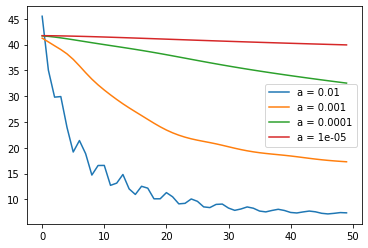

In [19]:
from sklearn.model_selection import train_test_split
a = [0.01, 0.001, 0.0001, 0.00001]
record = []
iris = fetch_openml(name='iris')
for i in range(0,4):
  X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=i*10)
  softmax_model = SoftMax()
  gd = GradientDescent(learning_rate=a[i], T=5, max_iters=50)
  best_w, train_acc_n, val_acc_n, train_loss_n, val_loss_n, grad_history_n = softmax_model.fit((X_train, y_train), (X_test, y_test), gd, np.unique(iris.target))
  plt.plot(val_loss_n, label="a = {}".format(a[i]))
  plt.legend()

run with k =  1
0.9649025069637883
0.3752409879998595
run with k =  2
0.9682451253481894
0.3895358690001558
run with k =  3
0.9665738161559888
0.3964277569998558
run with k =  4
0.9649025069637883
0.38636711399976775
run with k =  5
0.9649025069637883
0.4069791609999811
run with k =  6
0.9615598885793872
0.41096152899990557
run with k =  7
0.9604456824512535
0.400049183000192
run with k =  8
0.9593314763231199
0.39521604099991237
run with k =  9
0.9576601671309192
0.3996727869998722
run with k =  10
0.9571030640668523
0.40737563399989085
run with k =  11
0.9576601671309192
0.3985918489997857
run with k =  12
0.9571030640668523
0.40881632099990384
run with k =  13
0.9571030640668523
0.40370026900018274
run with k =  14
0.9571030640668523
0.4046307879998494
run with k =  15
0.9559888579387186
0.41895455799976844
run with k =  16
0.9571030640668523
0.4086078129998896
run with k =  17
0.9554317548746518
0.4104417639996427
run with k =  18
0.9515320334261839
0.4161781550001251
run with k = 

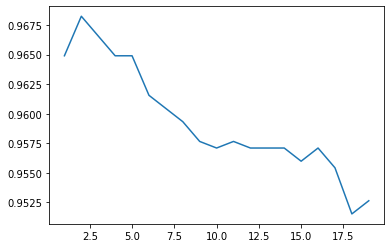

In [18]:
from sklearn.neighbors import KNeighborsClassifier as KNN
import time

X = digits.data
y = digits.target

val_acc = []
best_k = 0
best_acc = 0
time_best_k = 0
G=GridSearchCV(0,X,y)

for k in range(1,20):
  knn=KNN(k)
  print('run with k = ',k)
  start = time.perf_counter()
  val_acc_n = []
  for n in range(1,6):
    X_train,X_val,y_train,y_val = G.k_folds(n)
    knn.fit(X_train,y_train)
    val_acc_n.append(knn.score(X_val,y_val))
  end = time.perf_counter()
  print(np.mean(val_acc_n))
  print(end-start)

  if (best_acc < np.mean(val_acc_n)):
    best_acc = np.mean(val_acc_n)
    best_k = k
    time_best_k = end-start
  val_acc.append(np.mean(val_acc_n))
  
print("Best param found as k of {}, with accuracy score of {} and run-time of {}".format(best_k, best_acc, time_best_k))
plt.plot(range(1,20),val_acc)